### ДЗ:
Необходимо запустить практическую часть занятия, и посмотреть самому то, о чём говорили на лекции. 

По образу практики, попробуйте создать искусственный датасет с лишними столбцами. 
Целевую метку, при правильной обработке данных, формируйте таким образом, 
чтобы без затруднений её смогла описать линейная модель. 

Ориентируйтесь на то, что было показано во время занятия, и каждый шаг описывайте в markdown. 
Здесь важно видеть ваш ход мысли. Не бойтесь ошибиться или написать не то. 

Данное задание не имеет какого-то “правильного” решения. 
Цель - достичь базового понимания проблемы. Чем больше вы фантазируете, тем лучше :) 
Тем не менее, старайтесь представить те ситуации, которые по-вашему мнению могли бы быть в реальных данных. Успеха!

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

## Подготовим данные для анализа

In [2]:
# Создаём сэмпл

# Количество мужчин, женщин в США и России
american_man_samples = 10000
russian_man_samples = 5000
american_woman_samples = 4000
russian_woman_samples = 1000
samples = american_man_samples+russian_man_samples+american_woman_samples+russian_woman_samples

#Рост мужчин и женщин
man_height = np.random.randint(165, 196, american_man_samples+russian_man_samples)
woman_height = np.random.randint(155, 176, american_woman_samples+russian_woman_samples)
height = np.concatenate((man_height,woman_height), axis=0)

# Зарплата мужчин и женщин в США и России
american_man_salary = np.random.randint(1500, 7500, american_man_samples)
russian_man_salary = np.random.randint(300, 1500, russian_man_samples)
american_woman_salary = np.random.randint(500, 5500, american_woman_samples)
russian_woman_salary = np.random.randint(200, 1000, russian_woman_samples)
salary = np.concatenate((american_man_salary,russian_man_salary,
                                       american_woman_salary, russian_woman_salary), axis=0)

# Целевой признак - Мужчина/женщина
man = pd.Series(['man'] *(american_man_samples+russian_man_samples))
woman = pd.Series(['woman'] * (american_woman_samples+russian_woman_samples))
sex = np.concatenate((man, woman), axis=0)

# Количество населения в выборке США и России
USA = pd.Series([ 'USA' ] * (american_man_samples+american_woman_samples))
RUS = pd.Series([ 'RUS' ] * (russian_man_samples+russian_woman_samples))
country = pd.concat([USA, RUS])

#Лишний столбец наличие домашнего животного
has_animals = np.random.randint(0, 2, samples)

#Создаем Dataframe из данных
data = pd.DataFrame({'height': height, 'salary': salary, 'country':country, 'has_animals':has_animals, 'sex': sex})
data.index = pd.RangeIndex(0, len(data.index))
data.head(5)

,height,salary,country,has_animals,sex
0,166,3323,USA,1,man
1,183,1731,USA,0,man
2,173,7153,USA,0,man
3,171,2938,USA,0,man
4,168,4234,USA,0,man


In [3]:
#добавим выборочно шум в ячейках в 1% выборки
r = np.random.choice(a=samples, size=int(samples*0.01), replace=False) 

for i in range(int(samples*0.01)):
    rn = np.random.randint(0, 2)
    data.iloc[r[i], rn] = data.iloc[r[i], rn] * 1.6

In [4]:
#Удалим выборочно значения в ячейках в 10% выборки
r = np.random.choice(a=samples, size=int(samples*0.1), replace=False) 
print(r)
for i in range(int(samples*0.1)):
    data.iloc[r[i], np.random.randint(0,2)]=np.nan

[16692 15949 10248 ...  1467  3086   382]


## Проводим анализ данных:
Необходимо из представленых данных определить кто относится к мужчинам, кто к женщинам

In [5]:
#Смотрим размер данных
data.shape

(20000, 5)

In [6]:
#Смотрим в каких колонках отсутствуют данные
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   height       18999 non-null  float64
 1   salary       19001 non-null  float64
 2   country      20000 non-null  object 
 3   has_animals  20000 non-null  int32  
 4   sex          20000 non-null  object 
dtypes: float64(2), int32(1), object(2)
memory usage: 703.2+ KB


Видим, что в колонках height, salary имеются нулевые значения ( Non-Null меньше 20000). Значит будет что-то с ними делать

In [7]:
#Смотрим из каких уникальных значений состоят признаки в колонках
for col in data.columns:
    print(col, ':\n', data[col].unique())

height :
 [166.  183.  173.  171.  168.  175.  176.  167.  195.  193.  194.  172.
 177.  174.  182.  302.4 178.    nan 191.  188.  190.  181.  185.  187.
 180.  169.  189.  179.  186.  192.  165.  184.  170.  294.4 305.6 307.2
 275.2 270.4 310.4 267.2 288.  300.8 281.6 278.4 297.6 284.8 312.  273.6
 299.2 289.6 291.2 272.  280.  264.  292.8 283.2 286.4 265.6 308.8 296.
 159.  155.  156.  158.  162.  163.  161.  164.  160.  157.  249.6 268.8
 252.8 257.6 248.  260.8]
salary :
 [3323. 1731. 7153. ...  244.  222.  489.]
country :
 ['USA' 'RUS']
has_animals :
 [1 0]
sex :
 ['man' 'woman']


Видим, что country, sex - категориальный признак. Будем применять к ним OneHotEncoding

## Разобьем выборку на test / train

In [8]:
X = data.iloc[:, :-1]
y = data.iloc[:, -1:]
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=0.3, random_state=63, stratify=y)

## Предобработаем данные:

In [9]:
# заполним нулевые значения медианным значением по столбцу
Xtrain.loc[Xtrain[Xtrain['height'].isna()].index, 'height'] = Xtrain['height'].median()
Xtrain.loc[Xtrain[Xtrain['salary'].isna()].index, 'salary'] = Xtrain['salary'].median()
#Xtrain['height'].fillna(int(Xtrain['height'].median()), inplace=True)
#Xtrain['salary'].fillna(int(Xtrain['salary'].median()), inplace=True)

c:\program files\python38\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


смотрим наличие выбросов по каждому признаку

195.0

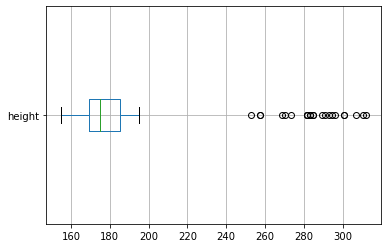

In [10]:
# смотрим наличие выбросов по росту

bp = Xtrain.boxplot(['height'],vert=False, return_type='dict')

# получаем правую часть верхнего уса
high_height = bp['whiskers'][1].get_xdata()[1]
high_height


Видим выбросы по росту свыше 195 см.

In [11]:
# Заменяем данные с выбросами на медианное значение

Xtrain.loc[Xtrain[Xtrain['height'] > high_height].index, 'height'] = Xtrain['height'].median()

Xtrain[Xtrain['height'] > high_height]['height'].count()


c:\program files\python38\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


0

9772.800000000001

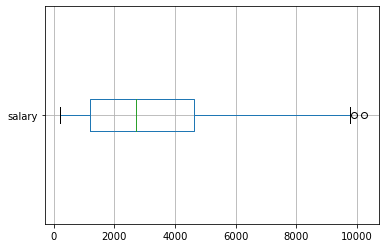

In [12]:
# смотрим наличие выбросов по зарплате

bp = Xtrain.boxplot(['salary'],vert=False, return_type='dict')

# получаем правую часть верхнего уса
high_salary = bp['whiskers'][1].get_xdata()[1]
high_salary

In [13]:
# Заменяем данные с выбросами на медианное значение

Xtrain.loc[Xtrain[Xtrain['salary'] > high_salary].index, 'salary'] = Xtrain['salary'].median()
Xtrain[Xtrain['salary'] > high_salary]['salary'].count()

c:\program files\python38\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


0

In [14]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [15]:
# Применим OneHotEncoding к обучающей выборке
ohe = OneHotEncoder()
df2 = pd.DataFrame(ohe.fit_transform(Xtrain[['country']]).toarray(), index=Xtrain.index)

# Нормализуем обучающую выборку
Xtrain_ohe = pd.concat([Xtrain, df2], axis=1)
Xtrain_ohe.drop(columns=['country'], inplace=True)
sc = StandardScaler()
Xtrain_sc = sc.fit_transform(Xtrain_ohe)
Xtrain_sc.shape

(6000, 5)

In [16]:
#2) применим к sex - Label Encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(ytrain['sex'])
Y = le.transform(ytrain['sex'])
Y.shape

(6000,)

In [17]:
from sklearn.linear_model import LogisticRegression

In [18]:
#Обучим модель
lr = LogisticRegression()
lr.fit(Xtrain_sc, Y)


LogisticRegression()

In [19]:
# Заполним тестовую выборку медианными значениями
Xtest.loc[Xtest[Xtest['height'].isna()].index, 'height'] = Xtest['height'].median()
Xtest.loc[Xtest[Xtest['salary'].isna()].index, 'salary'] = Xtest['salary'].median()


c:\program files\python38\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


195.0

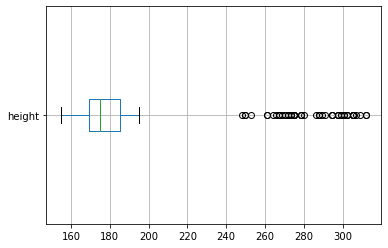

In [20]:
# строим boxplot
bp = Xtest.boxplot(['height'], vert=False, return_type='dict')

# получаем правую часть верхнего уса
high_height = bp['whiskers'][1].get_xdata()[1]
high_height

In [21]:
# Заменяем данные с выбросами на медианное значение

Xtest.loc[Xtest[Xtest['height'] > high_height].index, 'height'] = Xtest['height'].median()
Xtest[Xtest['height'] > high_height]['height'].count()

c:\program files\python38\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


0

9980.800000000001

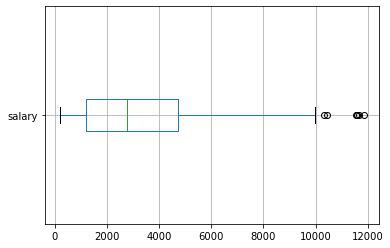

In [22]:
# строим boxplot
bp = Xtest.boxplot(['salary'], vert=False, return_type='dict')

# получаем правую часть верхнего уса
high_salary = bp['whiskers'][1].get_xdata()[1]
high_salary

In [24]:
# Заменяем данные с выбросами на медианное значение

Xtest.loc[Xtest[Xtest['salary'] > high_salary].index, 'salary'] = Xtest['salary'].median()
Xtest[Xtest['salary'] > high_salary]['salary'].count()

c:\program files\python38\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


0

In [25]:
# Применим OneHotEncoding к тестовой выборке
df3 = pd.DataFrame(ohe.transform(Xtest[['country']]).toarray(), index=Xtest.index)

Xtest_ohe = pd.concat([Xtest, df3], axis=1)
Xtest_ohe.drop(columns=['country'], inplace=True)

# Нормализуем тестовую выборку
Xtest_sc = sc.transform(Xtest_ohe)
Xtest_sc.shape

Yt = le.transform(ytest['sex'])
Yt.shape

(14000,)

In [26]:
# Посмотрим рещультаты обучения модели на тествой выборке
lr.score(Xtest_sc, Yt)

0.9747142857142858